In [95]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier as S
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tabulate import tabulate
import itertools
import winsound

In [2]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X_nt = X_nt.drop(index = 83)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [3]:
imputer_r = SimpleImputer(strategy = 'median', fill_value = 0)
scaler_r = StandardScaler()
X_nt_s_i = scaler_r.fit_transform(imputer_r.fit_transform(X_nt))
X_t_s_i = scaler_r.transform(imputer_r.transform(X_t))

In [111]:
def grid_searcher(param_grid, pipeline, scoring, X_nt = X_nt_s_i, y_nt = y_nt, cv = 5, verbose = 1, strat = False):
    tic = time.time()
    if strat:
        grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = StratifiedKFold(n_splits = cv), scoring = scoring, n_jobs = -1,
                               verbose = verbose, error_score = 'raise')
    else:
        grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs = -1, verbose = verbose,
                               error_score = 'raise')
    grid_search.fit(X_nt, y_nt)
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    best_model = grid_search.best_estimator_
    toc = time.time()
    print("Time Taken:", toc - tic)
    return best_params, best_model

In [6]:
def model_test(best_estimator, X_test = X_t_s_i, y_test = y_t, suppress_output = False, small_output = True):
    y_pred_test = best_estimator.predict(X_test)
    class_names = ['Class 0', 'Class 1']
    report_test = classification_report(y_test, y_pred_test, target_names = class_names)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
    if not(suppress_output):
        print("Classification Report on Test Set:")
        print(report_test)
        cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
        print("Confusion Matrix:")
        print(cm_table)
        plt.figure(figsize = (8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    if small_output:
        return report_test, cm_table, f1_score(y_test, y_pred_test)

In [7]:
# Assuming X contains the features and y contains the target variable

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
sgd_clf = SGDClassifier(random_state = 42)

# Fit the model on the training data
sgd_clf.fit(X_nt_s_i, y_nt)

# Predict on the test data
y_pred = sgd_clf.predict(X_t_s_i)

# Print classification report
print(classification_report(y_t, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       183
           1       0.50      0.19      0.28        26

    accuracy                           0.88       209
   macro avg       0.70      0.58      0.60       209
weighted avg       0.85      0.88      0.85       209



Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93       183
     Class 1       0.50      0.19      0.28        26

    accuracy                           0.88       209
   macro avg       0.70      0.58      0.60       209
weighted avg       0.85      0.88      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       178 |         5 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


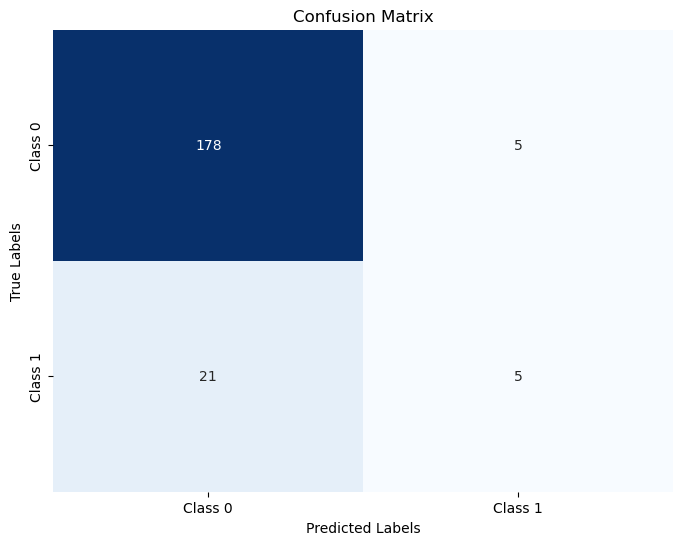

In [10]:
model_test(sgd_clf, small_output = False)

In [114]:
mparam_grid = {
    'model__loss': ['hinge', 'log_loss', 'modified_huber'],  # Loss function
    # loss: {'hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
    # 'modified_huber', 'squared_error'}
    'model__penalty': ['l1', 'l2', 'elasticnet'],        # Regularization penalty
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],          # Regularization strength
    'model__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'model__eta0': [0.01], # 0.1, 0.5, 1.0],                # Initial learning rate
    # 'max_iter': [1000, 2000, 3000],               # Maximum number of iterations
    'model__max_iter': [4000],               # Maximum number of iterations
    'model__tol': [1e-3, 1e-4, 1e-5],                    # Tolerance for stopping criteria
    # 'shuffle': [True, False],                     # Whether to shuffle training data
    # 'model__early_stopping': [True, False],              # Whether to use early stopping
    'model__early_stopping': [True],              # Whether to use early stopping
    'model__validation_fraction': [0.1, 0.2, 0.3],       # Fraction of training data to use for validation
    'model__n_iter_no_change': [5, 10, 20]               # Number of iterations with no improvement to stop training
}

In [115]:
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],  # Loss function
    # loss: {'hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
    # 'modified_huber', 'squared_error'}
    'penalty': ['l1', 'l2', 'elasticnet'],        # Regularization penalty
    'alpha': [0.0001, 0.001, 0.01, 0.1],          # Regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'eta0': [0.01], # 0.1, 0.5, 1.0],                # Initial learning rate
    # 'max_iter': [1000, 2000, 3000],               # Maximum number of iterations
    'max_iter': [4000],               # Maximum number of iterations
    'tol': [1e-3, 1e-4, 1e-5],                    # Tolerance for stopping criteria
    # 'shuffle': [True, False],                     # Whether to shuffle training data
    # 'early_stopping': [True, False],              # Whether to use early stopping
    'early_stopping': [True],              # Whether to use early stopping
    'validation_fraction': [0.1, 0.2, 0.3],       # Fraction of training data to use for validation
    'n_iter_no_change': [5, 10, 20]               # Number of iterations with no improvement to stop training
}

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best Hyperparameters: {'alpha': 0.0001, 'early_stopping': True, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 4000, 'n_iter_no_change': 20, 'penalty': 'elasticnet', 'tol': 0.001, 'validation_fraction': 0.3}
Time Taken: 87.65860104560852
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.97      0.92       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.85       209
   macro avg       0.44      0.48      0.46       209
weighted avg       0.76      0.85      0.80       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


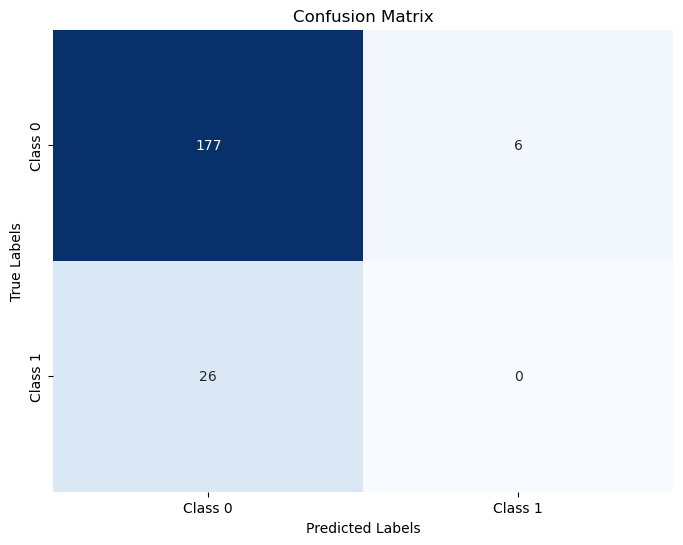

In [117]:
sg1 = S(random_state = 42)
best_params, best_model = grid_searcher(param_grid, sg1, 'f1')
model_test(best_model)
winsound.Beep(1000, 2000)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


C:\Users\aniru\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'alpha': 0.0001, 'early_stopping': True, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 4000, 'n_iter_no_change': 20, 'penalty': 'l2', 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.3}
Time Taken: 93.72687196731567
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.95      0.91       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.83       209
   macro avg       0.43      0.47      0.45       209
weighted avg       0.76      0.83      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


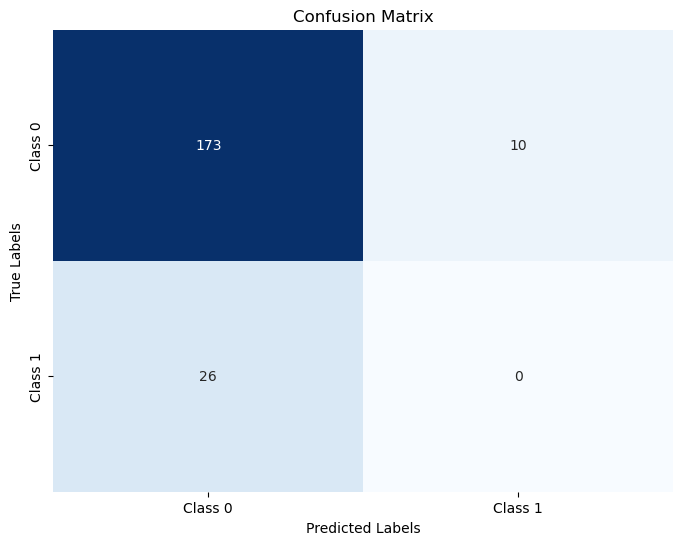

In [107]:
sg1 = S(random_state = 42)
best_params, best_model = grid_searcher(param_grid, sg1, 'recall')
model_test(best_model)
winsound.Beep(1000, 2000)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best Hyperparameters: {'alpha': 0.001, 'early_stopping': True, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 7000, 'n_iter_no_change': 5, 'penalty': 'l2', 'tol': 0.001, 'validation_fraction': 0.3}
Time Taken: 89.3384656906128
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      0.90      0.89       183
     Class 1       0.14      0.12      0.13        26

    accuracy                           0.80       209
   macro avg       0.51      0.51      0.51       209
weighted avg       0.79      0.80      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       165 |        18 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+


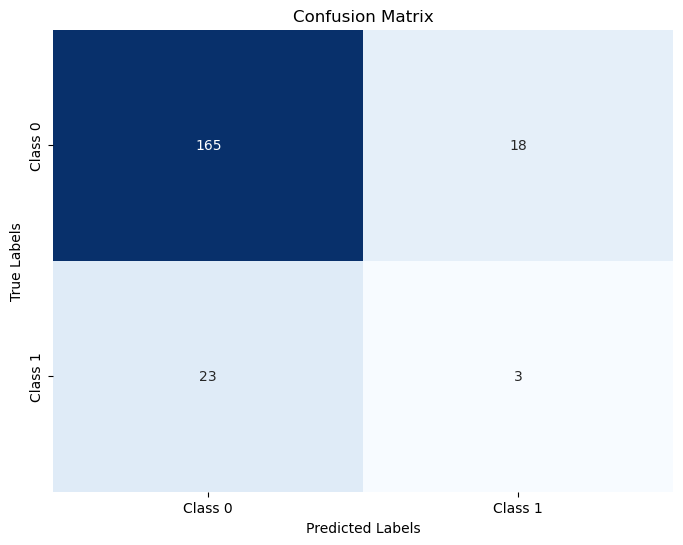

In [48]:
sg2 = S(random_state = 42)
best_params, best_model = grid_searcher(param_grid, sg2, 'f1')
model_test(best_model)
winsound.Beep(1000, 2000)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best Hyperparameters: {'alpha': 0.001, 'early_stopping': True, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 7000, 'n_iter_no_change': 5, 'penalty': 'l2', 'tol': 0.001, 'validation_fraction': 0.3}
Time Taken: 87.45770168304443
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      0.90      0.89       183
     Class 1       0.14      0.12      0.13        26

    accuracy                           0.80       209
   macro avg       0.51      0.51      0.51       209
weighted avg       0.79      0.80      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       165 |        18 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+


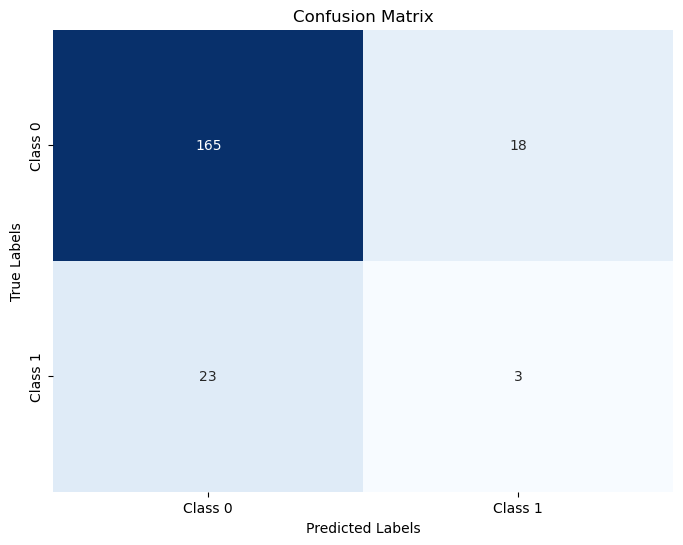

In [49]:
sg3 = S(random_state = 42)
best_params, best_model = grid_searcher(param_grid, sg3, 'matthews_corrcoef')
model_test(best_model)
winsound.Beep(1000, 2000)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best Hyperparameters: {'alpha': 0.001, 'early_stopping': True, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 7000, 'n_iter_no_change': 5, 'penalty': 'l2', 'tol': 0.001, 'validation_fraction': 0.3}
Time Taken: 88.48810815811157
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      0.90      0.89       183
     Class 1       0.14      0.12      0.13        26

    accuracy                           0.80       209
   macro avg       0.51      0.51      0.51       209
weighted avg       0.79      0.80      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       165 |        18 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+


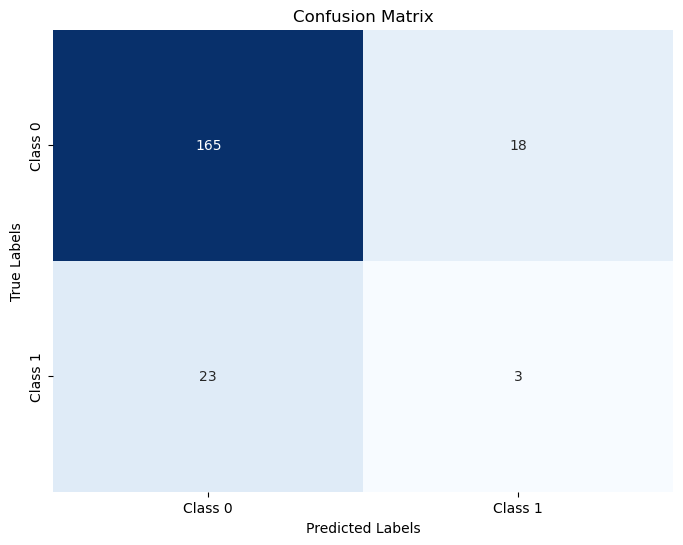

In [52]:
sg4 = S(random_state = 42)
best_params, best_model = grid_searcher(param_grid, sg4, 'f1')
model_test(best_model)
winsound.Beep(1000, 2000)

In [53]:
def make_sgd_pipeline():
    model = S(random_state = 42)
    imputer = SimpleImputer(strategy = 'median')
    scaler = StandardScaler()
    pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler),
        ('model', model)
    ])
    return pipeline

In [69]:
param_grid = {
    'model__loss': ['hinge', 'log_loss', 'modified_huber'],  # Loss function
    # loss: {'hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
    # 'modified_huber', 'squared_error'}
    'model__penalty': ['l1', 'l2', 'elasticnet'],        # Regularization penalty
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],          # Regularization strength
    'model__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'model__eta0': [0.01], # 0.1, 0.5, 1.0],                # Initial learning rate
    # 'max_iter': [1000, 2000, 3000],               # Maximum number of iterations
    'model__max_iter': [4000],               # Maximum number of iterations
    'model__tol': [1e-3, 1e-4, 1e-5],                    # Tolerance for stopping criteria
    # 'shuffle': [True, False],                     # Whether to shuffle training data
    # 'model__early_stopping': [True, False],              # Whether to use early stopping
    'model__early_stopping': [True],              # Whether to use early stopping
    'model__validation_fraction': [0.1, 0.2, 0.3],       # Fraction of training data to use for validation
    'model__n_iter_no_change': [5, 10, 20]               # Number of iterations with no improvement to stop training
}

In [64]:
new_list = ['M', 'GRADE', 'T', 'IVC INV', 'MAX DIA', 'AGE', 'APPROACH_1', 'APPROACH_2', 'N']
X_train_i = X_nt[new_list]
X_test_i = X_t[new_list]

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best Hyperparameters: {'model__alpha': 0.001, 'model__early_stopping': True, 'model__eta0': 0.01, 'model__learning_rate': 'optimal', 'model__loss': 'modified_huber', 'model__max_iter': 4000, 'model__n_iter_no_change': 10, 'model__penalty': 'l2', 'model__tol': 0.001, 'model__validation_fraction': 0.2}
Time Taken: 79.1977436542511
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.97      0.93       183
     Class 1       0.40      0.15      0.22        26

    accuracy                           0.87       209
   macro avg       0.64      0.56      0.57       209
weighted avg       0.83      0.87      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        22 |         4 |
+-----------+-----------+


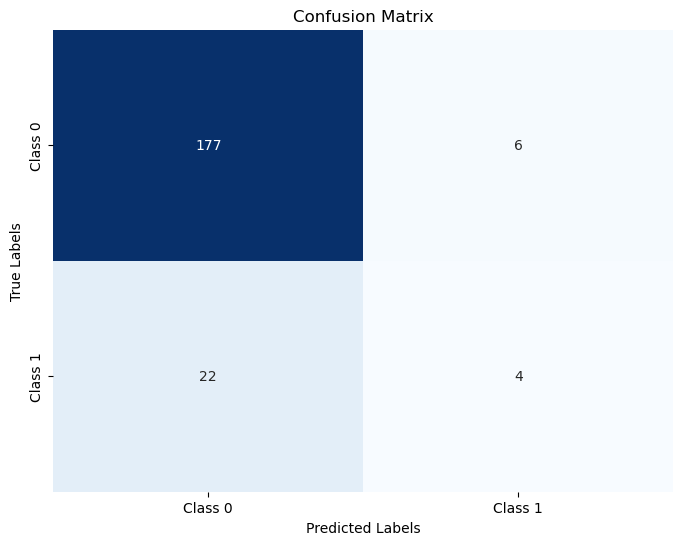

In [70]:
sgpipeline1 = make_sgd_pipeline()
best_params, best_model = grid_searcher(param_grid, sgpipeline1, 'f1', X_train_i, cv = 5)
model_test(best_model, X_test_i, y_t, False, False)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best Hyperparameters: {'model__alpha': 0.001, 'model__early_stopping': True, 'model__eta0': 0.01, 'model__learning_rate': 'optimal', 'model__loss': 'log_loss', 'model__max_iter': 4000, 'model__n_iter_no_change': 10, 'model__penalty': 'elasticnet', 'model__tol': 0.001, 'model__validation_fraction': 0.3}
Time Taken: 54.58056330680847
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      0.99      0.93       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.87       209
   macro avg       0.44      0.50      0.47       209
weighted avg       0.77      0.87      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       182 |         1 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


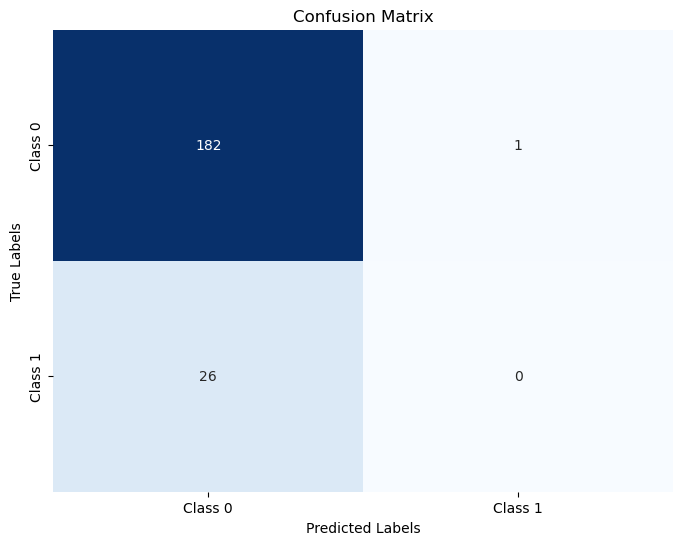

In [68]:
sgpipeline2 = make_sgd_pipeline()
best_params2, best_model2 = grid_searcher(param_grid, sgpipeline2, 'f1', X_train_i, cv = 5)
model_test(best_model2, X_test_i, y_t, False, False)

In [74]:
param_grid1 = {
    'model__loss': ['hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
                    'modified_huber', 'squared_error'],  # Loss function
    # loss: {'hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
    # 'modified_huber', 'squared_error'}
    'model__penalty': ['l1', 'l2', 'elasticnet'],        # Regularization penalty
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],          # Regularization strength
    'model__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'model__eta0': [0.01, 0.1, 0.5, 1.0],                # Initial learning rate
    # 'max_iter': [1000, 2000, 3000],               # Maximum number of iterations
    'model__max_iter': [3000, 4000, 5000],               # Maximum number of iterations
    # 'model__tol': [1e-3, 1e-4, 1e-5],                    # Tolerance for stopping criteria
    # 'shuffle': [True, False],                     # Whether to shuffle training data
    # 'model__early_stopping': [True, False],              # Whether to use early stopping
    # 'model__early_stopping': [True],              # Whether to use early stopping
    # 'model__validation_fraction': [0.1, 0.2, 0.3],       # Fraction of training data to use for validation
    # 'model__n_iter_no_change': [5, 10, 20]               # Number of iterations with no improvement to stop training
}

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best Hyperparameters: {'model__alpha': 0.0001, 'model__eta0': 0.5, 'model__learning_rate': 'adaptive', 'model__loss': 'perceptron', 'model__max_iter': 3000, 'model__penalty': 'l2'}
Time Taken: 75.5339457988739
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.87      0.89       183
     Class 1       0.26      0.31      0.28        26

    accuracy                           0.80       209
   macro avg       0.58      0.59      0.58       209
weighted avg       0.82      0.80      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       160 |        23 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


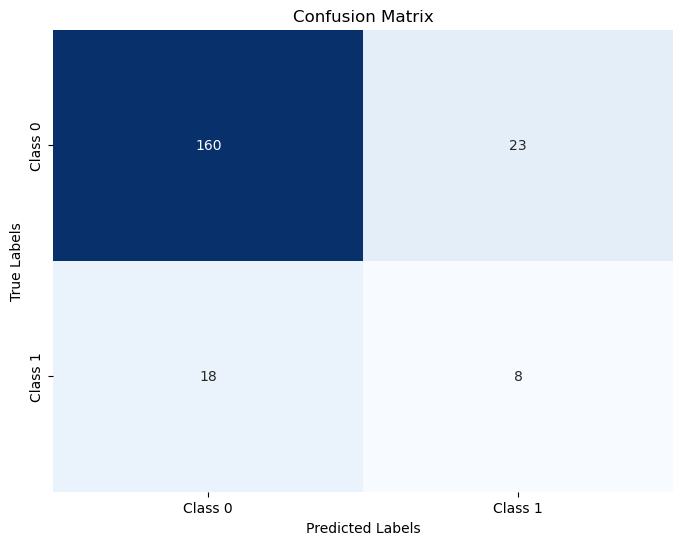

In [113]:
sgpipeline1 = make_sgd_pipeline()
best_params1, best_model1 = grid_searcher(param_grid1, sgpipeline1, 'f1', X_train_i, cv = 5, strat = True)
model_test(best_model1, X_test_i, y_t, False, False)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best Hyperparameters: {'model__alpha': 0.0001, 'model__eta0': 0.5, 'model__learning_rate': 'adaptive', 'model__loss': 'perceptron', 'model__max_iter': 3000, 'model__penalty': 'l2'}
Time Taken: 77.82253122329712
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.87      0.89       183
     Class 1       0.26      0.31      0.28        26

    accuracy                           0.80       209
   macro avg       0.58      0.59      0.58       209
weighted avg       0.82      0.80      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       160 |        23 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


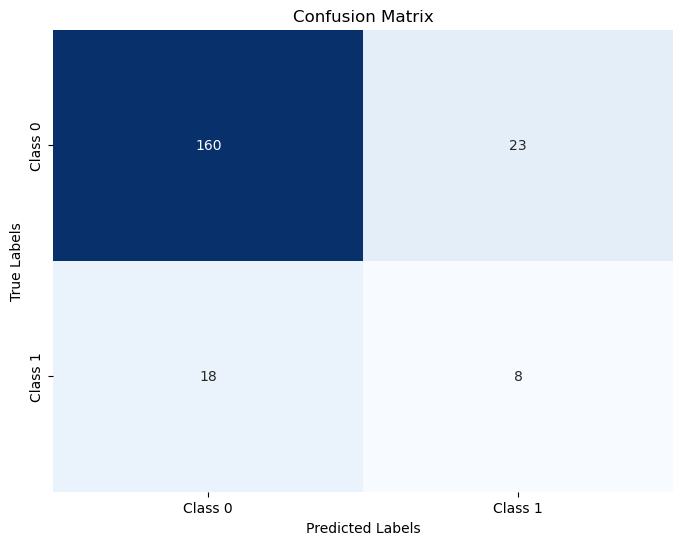

In [110]:
sgpipeline1 = make_sgd_pipeline()
best_params1, best_model1 = grid_searcher(param_grid1, sgpipeline1, 'f1', X_train_i, cv = 5)
model_test(best_model1, X_test_i, y_t, False, False)

In [81]:
param_grid2 = {
    # 'model__loss': ['hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
                    # 'modified_huber', 'squared_error'],  # Loss function
    # loss: {'hinge', 'perceptron', 'squared_hinge', 'log_loss', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive',
    # 'modified_huber', 'squared_error'}
    # 'model__penalty': ['l1', 'l2', 'elasticnet'],        # Regularization penalty
    # 'model__alpha': [0.0001, 0.001, 0.01, 0.1],          # Regularization strength
    # 'model__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    # 'model__eta0': [0.01, 0.1, 0.5, 1.0],                # Initial learning rate
    # 'max_iter': [1000, 2000, 3000],               # Maximum number of iterations
    # 'model__max_iter': [3000, 4000, 5000],               # Maximum number of iterations
    'model__tol': [1e-3, 1e-4, 1e-5],                    # Tolerance for stopping criteria
    'model__shuffle': [True, False],                     # Whether to shuffle training data
    'model__early_stopping': [True, False],              # Whether to use early stopping
    'model__early_stopping': [True],              # Whether to use early stopping
    'model__validation_fraction': [0.1, 0.15, 0.2, 0.25, 0.3],       # Fraction of training data to use for validation
    'model__n_iter_no_change': [5, 10, 15, 20]               # Number of iterations with no improvement to stop training
}

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'model__early_stopping': True, 'model__n_iter_no_change': 10, 'model__shuffle': False, 'model__tol': 0.001, 'model__validation_fraction': 0.2}
Time Taken: 8.829692363739014
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.91      0.91       183
     Class 1       0.37      0.38      0.38        26

    accuracy                           0.84       209
   macro avg       0.64      0.65      0.64       209
weighted avg       0.84      0.84      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       166 |        17 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


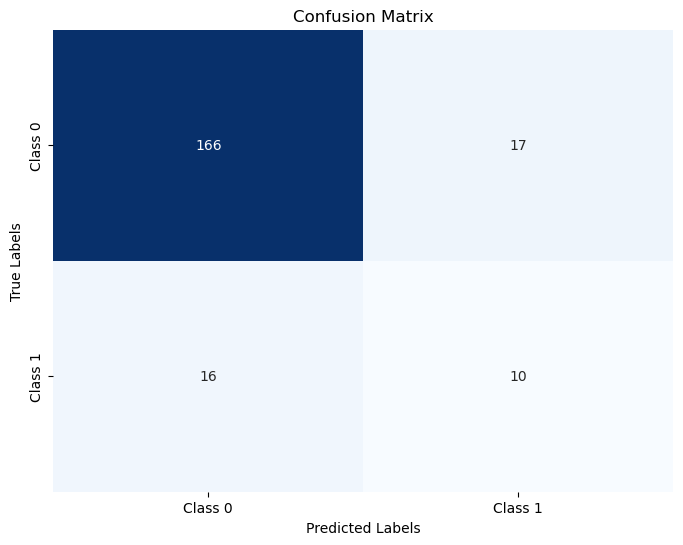

In [129]:
# sgpipeline2 = make_sgd_pipeline()
best_param2, best_model2 = grid_searcher(param_grid2, best_model1, 'f1', X_train_i, cv = 5)
model_test(best_model2, X_test_i, y_t, False, False)

In [120]:
len(X_train_i)

484